# Ada - Milestone 2
## 1. Preliminary data analysis
### Dataset: Beer reviews

### Understand data structure inside datasets
(From referenced paper in google sheets)

- Five stars / five-aspect rating system: **feel, look, smell, taste & overall**
- BA: 33 387 users, 66 051 beers, 1 586 259 reviews
- RB: 40 213 users, 110 419 beers, 2 924 127 reviews

'ba' system | 'rb' system
:----------:|:-----------:
![](./data/img/ba_rating_system.png) | ![](./data/img/rb_rating_system.png)

For both systems: 'rating' column (final score) is automatically generated based on the five aspects


In [9]:
# General libraries
import pandas as pd
import numpy as np
import os

# NLP libraries
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *

# Geospatial analysis
import geopandas as gpd

# Visualization libraries
import matplotlib.pyplot as plt
import importlib
import seaborn as sns


# import utils files
import src.utils.data_utils as data_utils
import src.utils.geospatial_utils as geospatial_utils
import src.utils.nlp_utils as nlp_utils
import src.utils.funfacts_utils as funfacts_utils
importlib.reload(data_utils)
importlib.reload(nlp_utils)
importlib.reload(geospatial_utils)
importlib.reload(funfacts_utils)

DATA_FOLDER = "../MA3/04_ADA/data/"


if you haven't yet, download the stopwrds and punkt_tab by running the following cell. It will be useful for the following analysis

In [6]:
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /Users/Julie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/Julie/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [10]:
##Reading the beer.csv file as a dataframe
beers_df = pd.read_csv(DATA_FOLDER+'matched_beer_data/beers.csv', low_memory=False)

##Call a function to preprocess the beer.csv dataframe
beers_df_copy = data_utils.preprocess_beers_df(beers_df)
display(beers_df_copy.head())
print('The shape of the dataframe for the beers.csv file is:', beers_df_copy.shape)

,ba_abv,ba_avg,ba_avg_matched_valid_ratings,ba_score,ba_beer_name,ba_brewery_name,ba_bros_score,ba_nbr_matched_valid_ratings,ba_nbr_ratings,ba_nbr_reviews,...,rb_beer_name,rb_beer_wout_brewery_name,rb_brewery_id,rb_brewery_name,rb_nbr_matched_valid_ratings,rb_nbr_ratings,rb_overall_score,rb_style,rb_style_score,rb_zscore
0,4.8,3.45,3.504067796610169,80.0,Legbiter,Strangford Lough Brewing Company Ltd,80.0,59,75,59,...,Strangford Lough Legbiter,Legbiter,4959,Strangford Lough,89,89,23.0,Golden Ale/Blond Ale,27.0,-0.69830388113311
1,6.0,3.86,3.768333333333333,NaN,St. Patrick's Ale,Strangford Lough Brewing Company Ltd,NaN,6,8,6,...,Strangford Lough St. Patricks Ale,Patricks Ale St,4959,Strangford Lough,11,11,52.0,Irish Ale,79.0,0.005754083235128498
2,4.2,3.56,3.580416666666667,82.0,St. Patrick's Best,Strangford Lough Brewing Company Ltd,90.0,48,64,48,...,Strangford Lough St. Patricks Best,Patricks Best St,4959,Strangford Lough,74,74,26.0,Bitter,25.0,-0.8621191741786616
3,4.8,3.96,3.96,NaN,St. Patrick's Gold,Strangford Lough Brewing Company Ltd,NaN,1,1,1,...,Strangford Lough St. Patricks Gold,Patricks Gold St,4959,Strangford Lough,4,4,NaN,Amber Ale,NaN,-0.7584908630826819
4,4.5,NaN,NaN,NaN,Sheelin Stout,The Sheelin Brewery,NaN,0,0,0,...,Sheelin Stout,Stout,17616,Sheelin,2,2,NaN,Mild Ale,NaN,-0.34727103754736977


The shape of the dataframe for the beers.csv file is: (45640, 25)


# 1.1 Create personalized dataset
## 1.1.1 Load the needed datasets

In [11]:
m_beers_raw = pd.read_csv(DATA_FOLDER + 'matched_beer_data/beers.csv', sep=',', header=[0, 1])
m_breweries_raw = pd.read_csv(DATA_FOLDER + 'matched_beer_data/breweries.csv', sep=',', header=[0, 1])
m_ratings_raw = pd.read_csv(DATA_FOLDER + 'matched_beer_data/ratings.csv', sep=',', header=[0, 1])

# # BA datasets
ba_users_raw = pd.read_csv(DATA_FOLDER + 'BeerAdvocate/users.csv', sep=',', header=[0])
ba_ratings_raw = data_utils.load_dict_like_text_file(DATA_FOLDER+'matched_beer_data/ratings_with_text_ba.txt',BLK_SIZE=20_000, MAX_BLK=1_000_000)
print("Size of 'ba' ratings dataframe: %d" % ba_ratings_raw.index.size)

# # RB datasets
rb_users_raw = pd.read_csv(DATA_FOLDER + 'RateBeer/users.csv', sep=',', header=[0])
rb_ratings_raw = data_utils.load_dict_like_text_file(DATA_FOLDER+'matched_beer_data/ratings_with_text_rb.txt',BLK_SIZE=20_000, MAX_BLK=3_000_000)
print("Size of 'rb' ratings dataframe: %d" % rb_ratings_raw.index.size)


LOADED 'ratings_with_text_ba.txt'                         
Size of 'ba' ratings dataframe: 289011
LOADED 'ratings_with_text_rb.txt'                         
Size of 'rb' ratings dataframe: 1020548


Create a dataframe to show the available columns in the datasets

In [23]:
col_info = pd.DataFrame({'ba_ratings_text': pd.Series(ba_ratings_raw.columns),
            'rb_ratings_text': pd.Series(rb_ratings_raw.columns),
            'beers_ba': pd.Series(m_beers_raw['ba'].columns.unique()),
            'beers_rb': pd.Series(m_beers_raw['rb'].columns.unique()),
            'breweries': pd.Series(m_breweries_raw['ba'].columns.unique()),
            'users_ba': pd.Series(ba_users_raw.columns.unique()),
            'users_rb': pd.Series(rb_users_raw.columns.unique()),
            'matched_ratings_ba': pd.Series(m_ratings_raw['ba'].columns.unique()),
            'matched_ratings_rb': pd.Series(m_ratings_raw['rb'].columns.unique())})
col_info

,ba_ratings_text,rb_ratings_text,beers_ba,beers_rb,breweries,users_ba,users_rb,matched_ratings_ba,matched_ratings_rb
0,beer_name,beer_name,abv,abv,id,nbr_ratings,nbr_ratings,abv,abv
1,beer_id,beer_id,avg,avg,location,nbr_reviews,user_id,appearance,appearance
2,brewery_name,brewery_name,avg_computed,avg_computed,name,user_id,user_name,aroma,aroma
3,brewery_id,brewery_id,avg_matched_valid_ratings,avg_matched_valid_ratings,nbr_beers,user_name,joined,beer_id,beer_id
4,style,style,ba_score,beer_id,NaN,joined,location,beer_name,beer_name
5,abv,abv,beer_id,beer_name,NaN,location,NaN,brewery_id,brewery_id
6,date,date,beer_name,beer_wout_brewery_name,NaN,NaN,NaN,brewery_name,brewery_name
7,user_name,user_name,beer_wout_brewery_name,brewery_id,NaN,NaN,NaN,date,date
8,user_id,user_id,brewery_id,brewery_name,NaN,NaN,NaN,overall,overall
9,appearance,appearance,brewery_name,nbr_matched_valid_ratings,NaN,NaN,NaN,palate,palate


## 1.1.2 Create dataset
Analyzing and merging the reviews with text from 'ba' and 'rb' datasets for maxizing the number of ratings to be used in our analysis

In [24]:
# Only different column from rb and ba is the 'review'
# Let's dive in to see what it contains
print("------ Values of this mysterious 'review' column -------")

display(ba_ratings_raw['review'].value_counts())

print("Interesting, some of the review values are false. What does it mean? Verifying if some of the values are NaN:")
display(ba_ratings_raw[ba_ratings_raw.review == 'False'].isna().sum())
print("None of the columns contains NaN values. CONCLUSION: DROP this useless column!\n")

ba_ratings = ba_ratings_raw.copy()
rb_ratings = rb_ratings_raw.copy()
ba_ratings.drop('review', axis=1, inplace=True)
print("----- Adjusted columns for ba and rb ratings -------")
display(pd.DataFrame([ba_ratings.columns, rb_ratings_raw.columns]))


------ Values of this mysterious 'review' column -------


review
True     272814
False     16197
Name: count, dtype: int64

Interesting, some of the review values are false. What does it mean? Verifying if some of the values are NaN:


beer_name       0
beer_id         0
brewery_name    0
brewery_id      0
style           0
abv             0
date            0
user_name       0
user_id         0
appearance      0
aroma           0
palate          0
taste           0
overall         0
rating          0
text            0
review          0
dtype: int64

None of the columns contains NaN values. CONCLUSION: DROP this useless column!

----- Adjusted columns for ba and rb ratings -------


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
1,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text


---

### A. Merge rb and ba ratings with text in a single dataframe

**Before** merging, normalize all score data to have same basis (Some are over /5 /10 or even /20)!

In [25]:
# Limit floating point decimals output
pd.options.display.float_format = '{:.2f}'.format

# Perform normalization of data
cols = ['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']
rb_ratings[cols] = rb_ratings[cols].astype(float)
ba_ratings[cols] = ba_ratings[cols].astype(float)

print("------ Stats (before normalization) -------")
stats = ['min', 'max', 'mean', 'std']
stats_df = pd.concat([rb_ratings[cols].add_suffix('_rb').agg(stats),ba_ratings[cols].add_suffix('_ba').agg(stats)], axis=1, names=['rb', 'ba'])
display(stats_df)

cols_to_normalize = ['overall', 'taste', 'aroma']
rb_ratings[cols_to_normalize] = rb_ratings[cols_to_normalize] / rb_ratings[cols_to_normalize].max() * 5.0

print("------ Stats (after normalization) -------")
stats_df = pd.concat([rb_ratings[cols].add_suffix('_rb').agg(stats),ba_ratings[cols].add_suffix('_ba').agg(stats)], axis=1, names=['rb', 'ba'])
display(stats_df)

------ Stats (before normalization) -------


,appearance_rb,aroma_rb,palate_rb,taste_rb,overall_rb,rating_rb,appearance_ba,aroma_ba,palate_ba,taste_ba,overall_ba,rating_ba
min,1.00,1.00,1.00,1.00,1.00,0.50,1.00,1.00,1.00,1.00,1.00,1.00
max,5.00,10.00,5.00,10.00,20.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00
mean,3.50,6.66,3.37,6.72,13.70,3.40,3.91,3.83,3.83,3.86,3.87,3.86
std,0.72,1.33,0.74,1.34,2.70,0.58,0.55,0.61,0.61,0.65,0.63,0.56


------ Stats (after normalization) -------


,appearance_rb,aroma_rb,palate_rb,taste_rb,overall_rb,rating_rb,appearance_ba,aroma_ba,palate_ba,taste_ba,overall_ba,rating_ba
min,1.00,0.50,1.00,0.50,0.25,0.50,1.00,1.00,1.00,1.00,1.00,1.00
max,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00
mean,3.50,3.33,3.37,3.36,3.42,3.40,3.91,3.83,3.83,3.86,3.87,3.86
std,0.72,0.67,0.74,0.67,0.67,0.58,0.55,0.61,0.61,0.65,0.63,0.56


In [26]:
# Third, join rb and ba users dataframe to have access to location
# join also brewery also to have access to location
# finally merge everything in a single dataframe
df_text_ratings = data_utils.merge_rb_ba_datasets(rb_ratings, rb_users_raw, ba_ratings, ba_users_raw, m_breweries_raw)
df_text_ratings.sample(5)

[INFO] :: Combining users and ratings from both websites...OK
[INFO] :: Combining breweries and ratings from both websites...OK
[INFO] :: Merging all datasets together...OK


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_id,appearance,aroma,...,text,nbr_ratings,nbr_reviews,user_name,joined,location_user,location_brewery,name,nbr_beers,source
978140,De Leite Merci Maman,262096,De Leite,9546,Belgian Ale,6.0,1441965600,349090,3.00,3.50,...,Aroma from the bottle indicated the presence o...,201.00,NaN,Nicolas_M,1418900400.00,Belgium,Belgium,De Leite,22,rb
216207,Maracaibo Especial,22257,Jolly Pumpkin Artisan Ales,9897,American Brown Ale,7.5,1119693600,tavernjef.1706,4.50,4.50,...,Dark plummy crimson with a finely set medium c...,2038.00,2037.00,tavernjef,1047034800.00,"United States, Minnesota","United States, Michigan",Jolly Pumpkin Artisan Ales,125,ba
499503,Hudson Valley Pillow Hat,494906,Hudson Valley Brewery,27030,Session IPA,4.0,1491213600,246421,4.00,3.50,...,"Nice citrus, mango, pineapple tropical hop aro...",1263.00,NaN,Mep3222,1361703600.00,"United States, New York","United States, New York",Hudson Valley Brewery,26,rb
633081,The Duck-Rabbit Brown Ale,38877,The Duck-Rabbit Craft Brewery,5175,Brown Ale,5.6,1147946400,20533,4.00,3.50,...,I happen to like American Brown Ale. This is ...,275.00,NaN,Bigsilky,1110193200.00,"United States, South Carolina","United States, North Carolina",The Duck-Rabbit Craft Brewery,41,rb
617517,Summit Sága IPA,165121,Summit Brewing Company,1233,India Pale Ale (IPA),6.4,1353150000,213109,3.00,3.50,...,Pretty good all around IPA. Can not beat it fo...,26.00,NaN,mlntroy23,1345802400.00,"United States, Iowa","United States, Minnesota",Summit Brewing Company,112,rb


---

### B. Removing duplicate reviews
Some users have the same (but different) ratings (and text review) on both rb and ba websites. After analysis of the "matched ratings" dataset, only the reviews matched for rb will be kept due to missing text reviews and ratings for the BA website.

In [27]:
df_text_ratings_no_duplicates = data_utils.remove_duplicate_reviews(df_text_ratings, m_ratings_raw)

Total # of combined ratings before filtering: 1318764
Total # of duplicate ratings to remove: 21964
[INFO] :: Dropping duplicates...OK
Total # of combined ratings after filtering: 1300486 --> Difference: 18278


#### Cleanup dataset by removing unused columns and verifying NA values

In [28]:
# Dropping unused columns: [beer_id, brewery_id, user_id, nbr_ratings, nbr_reviews, joined, nbr_beers]
df_ratings_cleaned = df_text_ratings_no_duplicates.copy()
df_ratings_cleaned.drop(columns=['beer_id', 'brewery_id', 'user_id', 'nbr_ratings', 'nbr_reviews', 'joined', 'nbr_beers'], inplace=True)

# Adjusting ambiguous column names
df_ratings_cleaned.rename(columns={'name': 'brewery_name'}, inplace=True)
df_ratings_cleaned.drop(columns=['index'], inplace=True)

# Checking NAs
print("!----- Testing for remaining NA values in the dataframe")
display(df_ratings_cleaned.isna().sum())

# Checking empty text reviews (might cause issues)
print("!----- Testing for empty text reviews in the dataframe")
display(df_ratings_cleaned[df_ratings_cleaned.text.apply(lambda x: len(x) < 1)])

# Perform cleaning of NA / empty values
print("Cleaning NAs from dataframe....")
df_ratings_cleaned = data_utils.clean_NA_empty_values(df_ratings_cleaned)

# For subcategories NAs, verify the rating and text associated with it
print("\n---- Investigating Na subcategories for ratings")
display(df_ratings_cleaned[df_ratings_cleaned.appearance.isna()][['appearance', 'taste', 'palate', 'aroma', 'overall', 'rating', 'text', 'source']].sample(10))
print("--> Since the ratings seem fair and the text is meaningful, these values will be kept!")

# Confirm cleanup
print("\n!----- Confirming cleanup")
display(df_ratings_cleaned.isna().sum())

!----- Testing for remaining NA values in the dataframe


beer_name               0
brewery_name            0
style                   0
abv                     0
date                    0
appearance           4814
aroma                4814
palate               4814
taste                4814
overall              4814
rating                  0
text                    0
user_name               4
location_user       40108
location_brewery        0
brewery_name            0
source                  0
dtype: int64

!----- Testing for empty text reviews in the dataframe


,beer_name,brewery_name,style,abv,date,appearance,aroma,palate,taste,overall,rating,text,user_name,location_user,location_brewery,brewery_name,source
219591,Bighorn Brown Ale,Silver Peak Restaurant & Brewery,American Brown Ale,5.0,1473933600,3.50,3.25,3.25,3.50,3.25,3.37,,gr8fulbeerhead,"United States, California","United States, Nevada",Silver Peak Restaurant & Brewery,ba


Cleaning NAs from dataframe....
[INFO] :: Cleaning empty text review...OK
[INFO] :: Merging NaN users' location with brewery location...OK

---- Investigating Na subcategories for ratings


,appearance,taste,palate,aroma,overall,rating,text,source
139408,NaN,NaN,NaN,NaN,NaN,3.75,Pours a clear orange-gold with minimal head. E...,ba
163334,NaN,NaN,NaN,NaN,NaN,4.00,Poured into an oversized wine glass. Color wa...,ba
153894,NaN,NaN,NaN,NaN,NaN,4.45,Had it on top and in a bottleA A normal black ...,ba
198868,NaN,NaN,NaN,NaN,NaN,2.00,Having become addicted to this style by consum...,ba
113412,NaN,NaN,NaN,NaN,NaN,3.00,A hazy light orange pour along with an ok nose...,ba
204782,NaN,NaN,NaN,NaN,NaN,4.25,This drinks like a tart Geueze when cold but a...,ba
167290,NaN,NaN,NaN,NaN,NaN,4.29,Reviewed from notes. Twenty-two ounce bottle s...,ba
191610,NaN,NaN,NaN,NaN,NaN,4.68,A joy to have this drop to be honest after the...,ba
167141,NaN,NaN,NaN,NaN,NaN,4.63,22oz bottle from the release a couple of weeks...,ba
191612,NaN,NaN,NaN,NaN,NaN,4.30,With the newer and more avant-garde brewers ma...,ba


--> Since the ratings seem fair and the text is meaningful, these values will be kept!

!----- Confirming cleanup


beer_name              0
brewery_name           0
style                  0
abv                    0
date                   0
appearance          4814
aroma               4814
palate              4814
taste               4814
overall             4814
rating                 0
text                   0
user_name              4
location_user          0
location_brewery       0
brewery_name           0
source                 0
dtype: int64

#### Casting columns to desired types

In [29]:
df_ratings_cleaned_new = data_utils.cast_columns_to_right_type(df_ratings_cleaned)

print("\n!--- Datatypes verification -------")
display(df_ratings_cleaned_new.dtypes)
df_ratings_cleaned_new.sample(5)

[INFO] :: Casting columns to right datatype...OK

!--- Datatypes verification -------


beer_name                   object
brewery_name                object
style                       object
abv                        float64
date                datetime64[ns]
appearance                 float64
aroma                      float64
palate                     float64
taste                      float64
overall                    float64
rating                     float64
text                        object
user_name                   object
location_user               object
location_brewery            object
brewery_name                object
source                      object
dtype: object

,beer_name,brewery_name,style,abv,date,appearance,aroma,palate,taste,overall,rating,text,user_name,location_user,location_brewery,brewery_name,source
1173490,Hoggleys Northamptonshire Bitter,Hoggleys,Bitter,4.00,2009-07-25 10:00:00,3.00,2.50,3.00,2.50,3.00,2.80,"50cl bottle from Westholme Stores, Goring. Amb...",berkshirejohn,England,England,Hoggleys,rb
15318,Transdermal Celebration,Beyond the Pale Brewing Company,Saison / Farmhouse Ale,7.00,2016-04-18 10:00:00,3.75,3.75,3.50,3.75,3.75,3.73,Growler Poured a clear golden color ale with a...,Phyl21ca,Canada,Canada,Beyond the Pale Brewing Company,ba
564224,Ramses Bier / Bierderie De Strijdende Kater,Ramses Bier,American Strong Ale,10.00,2016-01-17 11:00:00,3.00,3.50,3.00,3.50,3.50,3.40,Tap at Winterbierfestival Gouda. Clear amber w...,Maakun,Netherlands,Netherlands,Ramses Bier,rb
1190561,Deux Nigauds,Brasserie Artisanale La Botteresse de Sur-les-...,Belgian Strong Ale,8.00,2009-04-05 10:00:00,3.00,3.50,3.00,3.50,3.50,3.40,Bottle thanks to bu11zeye. Nose is banana nut ...,ilovedarkbeer,"United States, Virginia",Belgium,Brasserie Artisanale La Botteresse de Sur-les-...,rb
425910,Kehrwieder Phoenix Pale Ale,Kehrwieder Kreativbrauerei,American Pale Ale,5.70,2016-04-20 10:00:00,3.00,3.00,3.00,3.00,3.25,3.10,Bottled. A hazy golden beer with a yellowish h...,Ungstrup,Denmark,Germany,Kehrwieder Kreativbrauerei,rb


----

### C. Final step: transform the following columns : [country, style, beer] for easier usage of data

Some pre-filtering is needed to match style and beers that are really close together

1. Check out location values under users

In [30]:
# Separate States and Country (add state column, filled with N.A. if no state)
df_ratings_cleaned_states = data_utils.extract_states_from_country(df_ratings_cleaned_new)

display(df_ratings_cleaned_states['country_user'].value_counts())
print("Number of countries for users: ", df_ratings_cleaned_states['country_user'].unique().size)
display(df_ratings_cleaned_states['state_user'].value_counts())
print("Number of states for users: ", df_ratings_cleaned_states['state_user'].unique().size)

[INFO] :: Extracting country for users...OK
[INFO] :: Extracting country for brewery locations...OK
[INFO] :: Extracting states for users...OK
[INFO] :: Extracting states for brewery locations...OK


country_user
United States      687716
Canada             101920
Denmark             77282
England             64029
Sweden              53062
                    ...  
Palestine               1
Bouvet Island           1
Tanzania                1
Solomon Islands         1
Iraq                    1
Name: count, Length: 148, dtype: int64

Number of countries for users:  148


state_user
                   612769
 California         70315
 Pennsylvania       50787
 New York           40689
 Illinois           40310
 Texas              32736
 Washington         29264
 Ohio               28921
 New Jersey         28042
 Florida            26670
 Colorado           25463
 Minnesota          24852
 Virginia           23871
 Massachusetts      23581
 North Carolina     19393
 Michigan           16610
 Wisconsin          16496
 Georgia            15992
 Maryland           15393
 Oregon             15252
 Indiana            12940
 Arizona            11802
 Missouri           10571
 Tennessee           9424
 Connecticut         9218
 New Hampshire       8970
 Kentucky            7813
 Iowa                7454
 Idaho               6660
 Vermont             6203
 Nevada              4678
 Alabama             4597
 South Carolina      4568
 Maine               4506
 Kansas              4175
 Louisiana           3283
 Nebraska            3009
 Rhode Island        2805
 

Number of states for users:  51


2. Style of the beer

In [31]:
print("There is {0} styles of beer registered in the dataset".format(df_ratings_cleaned['style'].unique().size))
print("Let's group the styles into bigger categories. This is a great opportunity to ask our friend ChatGPT to help us!")

# Using ChatGPT to "cluster" and identify some generic categories for a pre-filtering of the styles
category_map = data_utils.get_beer_style_mapping()
df_ratings_cleaned['style_category'] = df_ratings_cleaned['style'].map(category_map).fillna('Other')

print("\n!------- Values after applying the mapping")
df_ratings_cleaned['style_category'].value_counts()

There is 169 styles of beer registered in the dataset
Let's group the styles into bigger categories. This is a great opportunity to ask our friend ChatGPT to help us!

!------- Values after applying the mapping


style_category
India Pale Ale (IPA)    246235
Other                   225541
Pale Ale                148363
Belgian Ale             108842
Sour Ale                 81660
Specialty & Seasonal     65628
Stout                    64060
Saison & Farmhouse       62268
Strong Ale               52237
Lager                    44838
Wheat Beer               41225
Strong Lager             30679
Pilsner                  30341
Hybrid Styles            30101
Porter                   23644
Dark Lager               22004
Other Ales               20851
Low Alcohol               1968
Name: count, dtype: int64

3. Try to filter out same beers but written differently (using the already match beer names in matched_dataset)

In [32]:
df_matched = beers_df_copy.copy()
display(df_matched[['ba_beer_name', 'rb_beer_name']].sample(5))

# Create mapping by keeping the shortest beer name between ba and rb
beer_name_mapping = {(ba_name if len(rb_name) < len(ba_name) else rb_name):(rb_name if len(rb_name) < len(ba_name) else ba_name) for ba_name, rb_name in zip(df_matched['ba_beer_name'].values, df_matched['rb_beer_name'].values)}
print("All keys mapped? {0}".format(len(beer_name_mapping.keys()) == len(df_matched['ba_beer_name'].values)))

# Apply the mapping to the beer_name 
cleaned_beer_names = df_ratings_cleaned['beer_name'].apply(lambda x: beer_name_mapping[x] if x in beer_name_mapping.keys() else x)

# Everything good
df_ratings_cleaned.loc[:,'beer_name'] = cleaned_beer_names

,ba_beer_name,rb_beer_name
7225,DIPA Underground,To Øl DIPA Underground
25026,Tree Star,The Brew Gentlemen Tree Star
14507,Daily Affirmation,Arts District Daily Affirmation
36424,Morning Glory,Birdfish Morning Glory
32170,Vitis Reductus Porter,Outer Banks Vitis Reductus Porter


All keys mapped? True


**EXPORT** the cleaned dataframe to CSV file

In [ ]:
#OUTPUT_FOLDER = 'local_data/'
OUTPUT_FOLDER = '../MA3/04_ADA/data/'

#df_ratings_cleaned.to_csv(OUTPUT_FOLDER + 'cleaned_ratings.csv', sep=',', header=True, encoding='utf-8')
print("Dataframe exported to '{0}'!".format(OUTPUT_FOLDER + 'cleaned_ratings.csv'))

Dataframe exported to '../MA3/04_ADA/data/cleaned_ratings.csv'!


---

### Investigating the created dataframe containing reviews of beers by countries and styles

1. Look at the yearly and monthly distribution of data (reviews)

> This gives a glance of how the reviews are spread over the years. The monthly bar plot is independant of the years (using all the reviews)


In [39]:
# IF needed, load the cleaned dataset from .csv file
DATA_INPUT_FOLDER = "../MA3/04_ADA/data/"

df_ratings_cleaned = pd.read_csv(DATA_INPUT_FOLDER + "cleaned_ratings.csv", delimiter=',', header=[0], low_memory=False)

In [40]:
df_ratings_cleaned

,Unnamed: 0,beer_name,brewery_name,style,abv,date,appearance,aroma,palate,taste,...,user_name,location_user,location_brewery,brewery_name.1,source,country_user,country_brewery,state_user,state_brewery,style_category
0,0,Legbiter,Strangford Lough Brewing Company Ltd,English Pale Ale,4.80,2013-02-13 11:00:00,4.25,4.50,3.25,3.75,...,brewdude1982,"United States, North Carolina",Northern Ireland,Strangford Lough Brewing Company Ltd,ba,United States,Northern Ireland,North Carolina,NaN,Pale Ale
1,1,Legbiter,Strangford Lough Brewing Company Ltd,English Pale Ale,4.80,2013-01-09 11:00:00,4.00,3.75,3.50,3.50,...,AgentMunky,"United States, New York",Northern Ireland,Strangford Lough Brewing Company Ltd,ba,United States,Northern Ireland,New York,NaN,Pale Ale
2,2,Legbiter,Strangford Lough Brewing Company Ltd,English Pale Ale,4.80,2012-11-17 11:00:00,3.00,3.50,2.50,2.50,...,ferrari29,"United States, Illinois",Northern Ireland,Strangford Lough Brewing Company Ltd,ba,United States,Northern Ireland,Illinois,NaN,Pale Ale
3,3,Legbiter,Strangford Lough Brewing Company Ltd,English Pale Ale,4.80,2012-07-14 10:00:00,4.00,3.50,4.00,3.50,...,OtherShoe2,"United States, Massachusetts",Northern Ireland,Strangford Lough Brewing Company Ltd,ba,United States,Northern Ireland,Massachusetts,NaN,Pale Ale
4,4,Legbiter,Strangford Lough Brewing Company Ltd,English Pale Ale,4.80,2012-04-28 10:00:00,4.50,3.00,3.50,2.50,...,brentk56,"United States, North Carolina",Northern Ireland,Strangford Lough Brewing Company Ltd,ba,United States,Northern Ireland,North Carolina,NaN,Pale Ale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300481,1318759,Korça 01 Lager Beer,Birra Korça,Pale Lager,4.10,2012-11-15 11:00:00,2.00,1.50,2.00,1.50,...,ogivlado,Croatia,Albania,Birra Korça,rb,Croatia,Albania,NaN,NaN,Lager
1300482,1318760,Korça 01 Lager Beer,Birra Korça,Pale Lager,4.10,2012-11-13 11:00:00,3.00,1.50,2.00,1.50,...,Marko,Croatia,Albania,Birra Korça,rb,Croatia,Albania,NaN,NaN,Lager
1300483,1318761,Korça 01 Lager Beer,Birra Korça,Pale Lager,4.10,2012-11-11 11:00:00,2.00,1.00,2.00,1.50,...,heavy,Croatia,Albania,Birra Korça,rb,Croatia,Albania,NaN,NaN,Lager
1300484,1318762,Korça 01 Lager Beer,Birra Korça,Pale Lager,4.10,2011-09-27 10:00:00,3.00,2.00,2.00,2.00,...,Quack-Duck,Germany,Albania,Birra Korça,rb,Germany,Albania,NaN,NaN,Lager


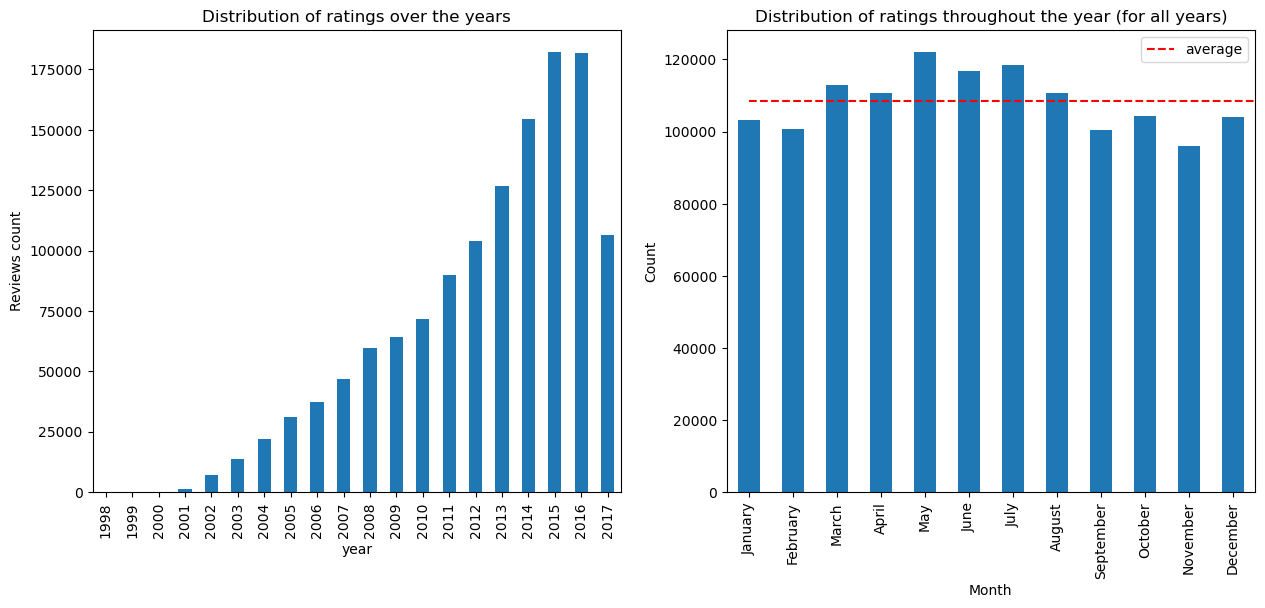

In [41]:
df_ratings_cleaned["date"] = pd.to_datetime(df_ratings_cleaned["date"])
fig, ax = plt.subplots(1,2, figsize=(15,6))
df_ratings_cleaned.groupby(df_ratings_cleaned['date'].dt.year).size().plot(kind='bar', ax=ax[0])
ax[0].set_title('Distribution of ratings over the years')
ax[0].set_xlabel('year')
ax[0].set_ylabel('Reviews count')
df_ratings_cleaned.groupby(df_ratings_cleaned['date'].dt.month).size().plot(kind='bar', ax=ax[1])
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
ax[1].plot([0,12],[df_ratings_cleaned.groupby(df_ratings_cleaned['date'].dt.month).size().apply('mean')]*2, color='red', linestyle='--', label='average')
ax[1].set_title('Distribution of ratings throughout the year (for all years)')
ax[1].set_xticklabels(months)
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Count')
ax[1].legend()
plt.show()

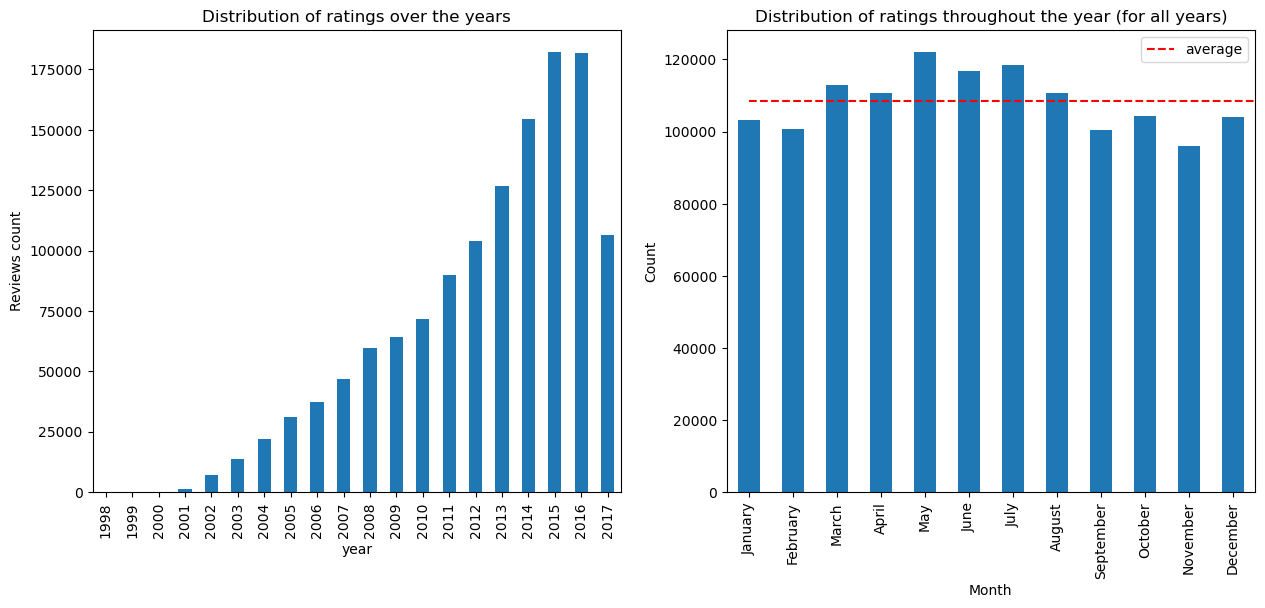

In [42]:
df_ratings_cleaned["date"] = pd.to_datetime(df_ratings_cleaned["date"])
fig, ax = plt.subplots(1,2, figsize=(15,6))
df_ratings_cleaned.groupby(df_ratings_cleaned['date'].dt.year).size().plot(kind='bar', ax=ax[0])
ax[0].set_title('Distribution of ratings over the years')
ax[0].set_xlabel('year')
ax[0].set_ylabel('Reviews count')
df_ratings_cleaned.groupby(df_ratings_cleaned['date'].dt.month).size().plot(kind='bar', ax=ax[1])
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
ax[1].plot([0,12],[df_ratings_cleaned.groupby(df_ratings_cleaned['date'].dt.month).size().apply('mean')]*2, color='red', linestyle='--', label='average')
ax[1].set_title('Distribution of ratings throughout the year (for all years)')
ax[1].set_xticklabels(months)
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Count')
ax[1].legend()
plt.show()

Comment:
- Most reviews were made between 2013 and 2017. Later, we will use a climatic dataset, where the year 2013 will be the reference for climate.
- The number of reviews per months is pretty constant. This is good as we will do seasonal analysis of reviews. Having roughly the same number of reviews per month ensures that the data is well-equilibrated.

2. Distribution of ratings per style for a specefied country

> Here the goal is to provide quick insights of the distribution of the ratings for a selected country

Total # of ratings for Belgium: 26126


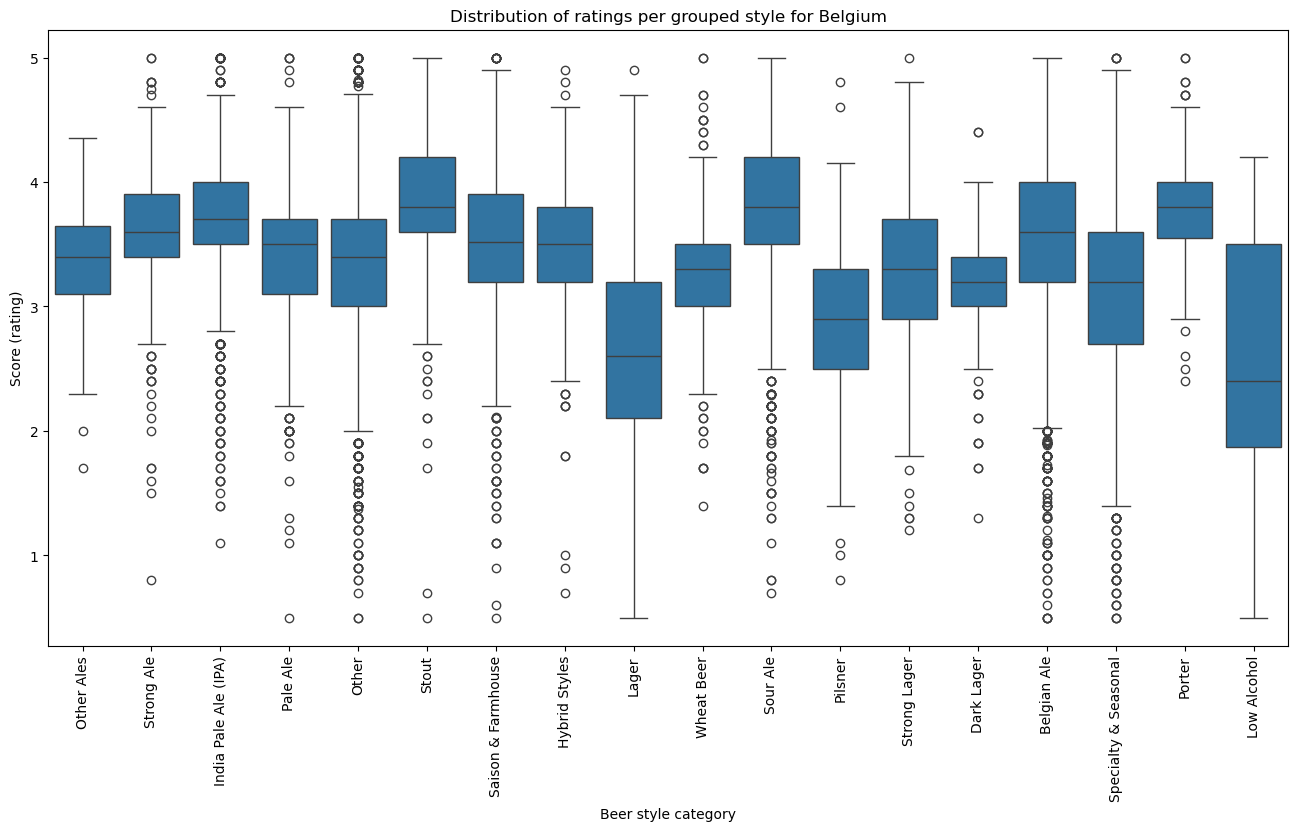

In [43]:
country = 'Belgium'
cols = ['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

df_selected_country = df_ratings_cleaned[df_ratings_cleaned.country_user == country]

print("Total # of ratings for {0}: {1}".format(country, df_selected_country['rating'].count()))

plt.figure(figsize=(16,8))
sns.boxplot(x='style_category', y='rating', data=df_selected_country)
plt.xticks(rotation=90)
plt.title('Distribution of ratings per grouped style for {0}'.format(country))
plt.xlabel('Beer style category')
plt.ylabel('Score (rating)')
plt.show()

3. Look at best rated beer style per country

In [44]:
def get_top_n(df, group, column, n): 
    return df.groupby(group).mean().sort_values(by=column,ascending=False)[:n]

cols = ['rating', 'overall', 'palate', 'taste', 'appearance', 'aroma', 'style_category']
df_ratings_cleaned.groupby(['country_user'])[cols].apply(get_top_n, group='style_category', column='rating', n=1)[['rating', 'overall', 'palate', 'taste', 'appearance', 'aroma']]

,,rating,overall,palate,taste,appearance,aroma
country_user,style_category,,,,,,
Abkhazia,Other,4.80,5.00,5.00,4.00,5.00,5.00
Afghanistan,Strong Ale,4.40,4.75,5.00,4.00,4.00,4.00
Albania,Other,5.00,5.00,5.00,5.00,5.00,5.00
Algeria,Strong Lager,3.90,4.00,3.00,4.50,4.00,3.50
Andorra,Wheat Beer,4.69,4.75,4.75,4.75,4.75,4.50
...,...,...,...,...,...,...,...
Uruguay,Pale Ale,4.10,4.25,5.00,4.00,4.00,3.50
Venezuela,Porter,3.75,4.00,3.50,3.75,3.00,3.75
Vietnam,India Pale Ale (IPA),4.28,4.42,4.08,4.25,4.08,4.25


# 2. Funfacts

In [46]:
# Reading the breweries.csv file as a dataframe
beers_df = pd.read_csv(DATA_FOLDER+'cleaned_ratings.csv', low_memory=False, index_col=0)

# Making a copy to keep the original dataframe unmodified
beers_df_copy = beers_df.copy()

# Remove 'style_category' other and other_Ales
beers_df_copy= beers_df_copy[~beers_df_copy['style_category'].isin(['Other'])]

## Fun fact #1 - Bob travels from Switzerland to UK (using rating score column)

In [47]:
#grouping of styles into 17 style categories 
nlp_utils.plot_beer_mapping() 

In [49]:
# Filtering rows where country_brewery is 'Switzerland' and 'England'
filtered_df_swit = beers_df_copy.loc[beers_df_copy['country_user'] == 'Switzerland', 'style_category'].unique()
filtered_df_uk = beers_df_copy.loc[beers_df_copy['country_user'] == 'England', 'style_category'].unique()

# Finding the intersection of styles
common_styles = set(filtered_df_swit) & set(filtered_df_uk)

merged_rating_funfact_1_df, pivot_rating_sorted_funfact_1_df = funfacts_utils.df_funfact_1(beers_df_copy) 

# Calculating p-values
p_vals = funfacts_utils.calculate_p_values(beers_df_copy)

fig_funfact1 = funfacts_utils.plot_funfact_1(len(common_styles), pivot_rating_sorted_funfact_1_df, merged_rating_funfact_1_df, p_vals)

# Displaying the plot
fig_funfact1.show()

# Saving the plot as html and svg formats
funfacts_utils.save_plot_as_html(fig_funfact1, './website/_includes/fig_funfact1.html')
funfacts_utils.save_plot_as_svg(fig_funfact1, './website/assets/figures/fig_funfact1.svg')


## Comments:
- This bar plot shows a comparison of the average rating score for the 17 beer styles between Switzerland and England. 

- The difference on the average rating score between the two countries is decreasing as we go from the left to the right on the plot. For instance, the 'Low Alcohol' style has the larger difference and the 'Strong Ale' style had the smaller one.

- The three beer styles that are significant in terms of the difference between Switzerland and England are the ones with a red star on top, i.e 'Other Ales', 'Specialty & Seasonal', and 'Sour Ale'. The significance was tested using t-tests.

- The two beer styles that have the highest average rating score in Belgium and England are 'Stout', and 'Porter'.

## Fun fact #2 - Bob travels from UK to Belgium

In [ ]:
belgium_beers, rating_by_year_beer_filtered = funfacts_utils.df_funfact_2(beers_df_copy)  
fig_funfact2 = funfacts_utils.plot_funfact_2(rating_by_year_beer_filtered)

# Displaying the plot
fig_funfact2.show()

# Saving the plot as html and svg formats
funfacts_utils.save_plot_as_html(fig_funfact2, './website/_includes/fig_funfact2.html')
funfacts_utils.save_plot_as_svg(fig_funfact2, './website/assets/figures/fig_funfact2.svg')

## Comment:
- This plot shows the distribution of the average beer ratings by year for three beer names which are consistent over all the years. 

- The beer style which has the highest average rating is the 'Trappistes Rochefort 10' beer.

## Fun fact #3 - Bob travels from Belgium to Canada 

In [ ]:
beer_avg_rating, belgium_data, canada_data = funfacts_utils.df_funfact_3(beers_df_copy)
fig_funfact3 = funfacts_utils.plot_funfact_3(beer_avg_rating, belgium_data, canada_data)

# Displaying the plot
fig_funfact3.show()

# Saving the plot as html and svg formats
funfacts_utils.save_plot_as_html(fig_funfact3, './website/_includes/fig_funfact3.html')
funfacts_utils.save_plot_as_svg(fig_funfact3, './website/assets/figures/fig_funfact3.svg')

## Comment:
- These pie charts shows the distribution of the beer Styles in Belgium and Canada based on rating counts fpr eahc style.

- The beer style with the highest count i.e the most liked from the users in Canada is 'India Pale Ale IPA' style and in Belgium is 'Belgian Ale' style.

## Fun fact #4 - Bob travels from Canada to the USA

In [ ]:
us_data, state_avg_ratings = funfacts_utils.df_funfact_4(beers_df_copy)
most_popular_brewery = funfacts_utils.df_funfact_4_brewery(us_data)
fig_funfact4 = funfacts_utils.plot_funfact_4_brewery(most_popular_brewery)

# Displaying the plot
fig_funfact4.show()

# Saving the plot as html and svg formats
funfacts_utils.save_plot_as_html(fig_funfact4, './website/_includes/fig_funfact4.html')
funfacts_utils.save_plot_as_svg(fig_funfact4, './website/assets/figures/fig_funfact4.svg')

## Comment:
- This plot shows the distribution of the most popular brewery in each state. 
- In the plot, each state has a unique popular brewery name which is displayed with a different color. 
- Newyork state is the one with the highest count for its corresponding brewery. 

# 3. Natural language processing

In [53]:
# User defined variables
USE_PREPROCESSED_DATA_CSV = True # Set to True to use preprocessed data file, False to preprocess data locally
USE_DOWNSAMPLED_DATA_CSV = False # Set to True to create a downsampled data file, False to create the file locally
USE_DOWNSAMPLED_DATA = False # Set to True to use the downsampled data, False to use the full data

# File paths
CLEANED_FID = DATA_FOLDER+'cleaned_ratings.csv'
PREPROCESSED_FID = DATA_FOLDER+'preprocessed_ratings.csv'
DOWNSAMPLED_FID = DATA_FOLDER+'downsampled_preprocessed_ratings.csv'

## 3.1 Load DataFrame

In [54]:
rawdata = pd.read_csv(CLEANED_FID, low_memory=False, encoding='utf-8')

## 3.2 pre-pocess data

In [55]:
if USE_PREPROCESSED_DATA_CSV:
    rawdata = pd.read_csv(PREPROCESSED_FID, low_memory=False)

    # Drop rows with Nan values in the 'preprocessed text' column
    rawdata = rawdata.dropna(subset=['preprocessed text'])
else:
    # Apply the preprocess_text function to execute text preprocessing steps
    rawdata['preprocessed text'] = rawdata['text'].apply(nlp_utils.preprocess_text)

    # Drop rows with Nan values in the 'preprocessed text' column
    rawdata = rawdata.dropna(subset=['preprocessed text'])

    # Save the preprocessed text to a new CSV file
    rawdata.to_csv(PREPROCESSED_FID, index=False)


## 3.3 Visualization of Text Data

Here we save wordcloud for all beer types for the website. Because plotting 17 wordcloud in a full image would not be easily readable. We chose to plot a wordcloud for a specific style: Stout. Indeed, we saw above that it's one of the styles most appreciated by the english. 

In [56]:
df=rawdata.copy()
#generate the world cloud and save them for the website !
nlp_utils.generate_wordcloud_country(df,'England')





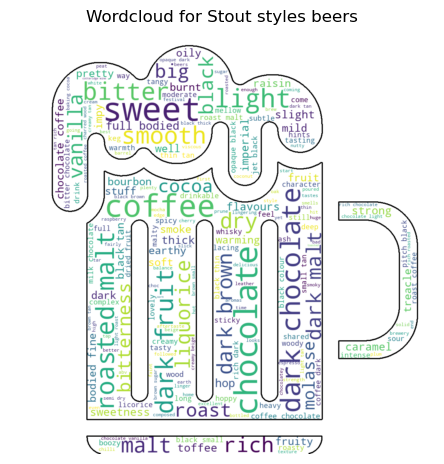

In [57]:
df_england=rawdata[rawdata['country_user']=='England']
df_stout = df_england[df_england['style_category']=='Stout']
nlp_utils.generate_wordclouds(df_stout,seasonal=False)

/var/folders/7l/ltdxzx1s3dj_sz2kw6_5g8k00000gn/T/ipykernel_24041/990322514.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7l/ltdxzx1s3dj_sz2kw6_5g8k00000gn/T/ipykernel_24041/990322514.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7l/ltdxzx1s3dj_sz2kw6_5g8k00000gn/T/ipykernel_24041/990322514.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

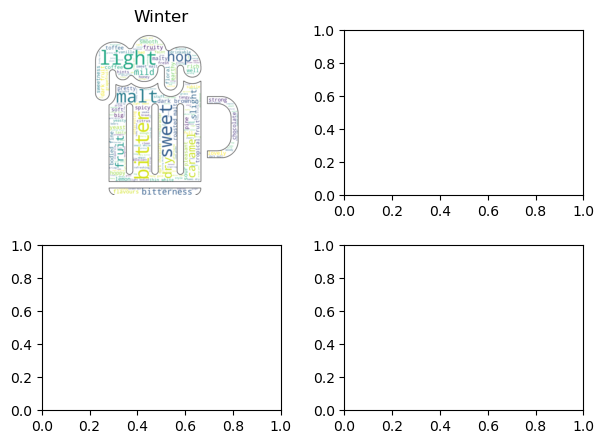

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [59]:
#plotting the wordclouds accross different seasons in england
df_england=rawdata[rawdata['country_user']=='England']


# Add a 'season' column to the DataFrame
df_england["date"] = pd.to_datetime(df_england["date"])
df_england['season_num'] = df_england['date'].copy()
df_england['season_num'] = df_england['season_num'].apply(geospatial_utils.get_season)

nlp_utils.generate_wordclouds(df_england,'England')

## 3.4 Sentiment analysis

Below we define Liked, Disliked and Polarizing beers. Liked beers are defined as beers with standard deviation one above the average standard deviation. Disliked beers are dedined as beers with standard deviations one below the average standard deviation. Polarizing beers, are defined when looking at the distribution of the standard deviations. We define a Polarizing beer as a beer which has 90% of standard deviation of the distrubition of the standards deviations. We apply this labelling technique to the whole dataset and we also apply it based on the preferences of users in their home country. 

In [60]:
sorted_ratings = df['rating'].sort_values()
sd = sorted_ratings.std()
avg = sorted_ratings.mean()
one_sigma = avg + sd
two_sigma = avg + 2 * sd
three_sigma = avg + 3 * sd
minus_one_sigma = avg - sd
minus_two_sigma = avg - 2 * sd
minus_three_sigma = avg - 3 * sd


# Add an average score, standard deviation and number of ratings column to the data frame for each beer
df['avg_score'] = df.groupby('beer_name')['rating'].transform('mean')
df['std_score'] = df.groupby('beer_name')['rating'].transform('std')
df['num_ratings'] = df.groupby('beer_name')['rating'].transform('count')

# Top 90% of standard deviation scores
too_high_std = df['std_score'].quantile(0.9)

#  Define each beer as liked, neutral, disliked and polarizing based on the thresholds
liked_threshold = one_sigma
disliked_threshold = minus_one_sigma
polarizing_threshold = too_high_std
significant_number_of_ratings = 2 # Minimum number of ratings to consider a beer

df['rating_label'] = df.apply(nlp_utils.apply_rating, axis=1, args=(liked_threshold, disliked_threshold, polarizing_threshold))
# Categorize the beers based on their ratings for every country
df = nlp_utils.calculate_ratings_by_country(df, significant_number_of_ratings,liked_threshold, disliked_threshold)
df_canada=df[df['country_user']=='Canada']



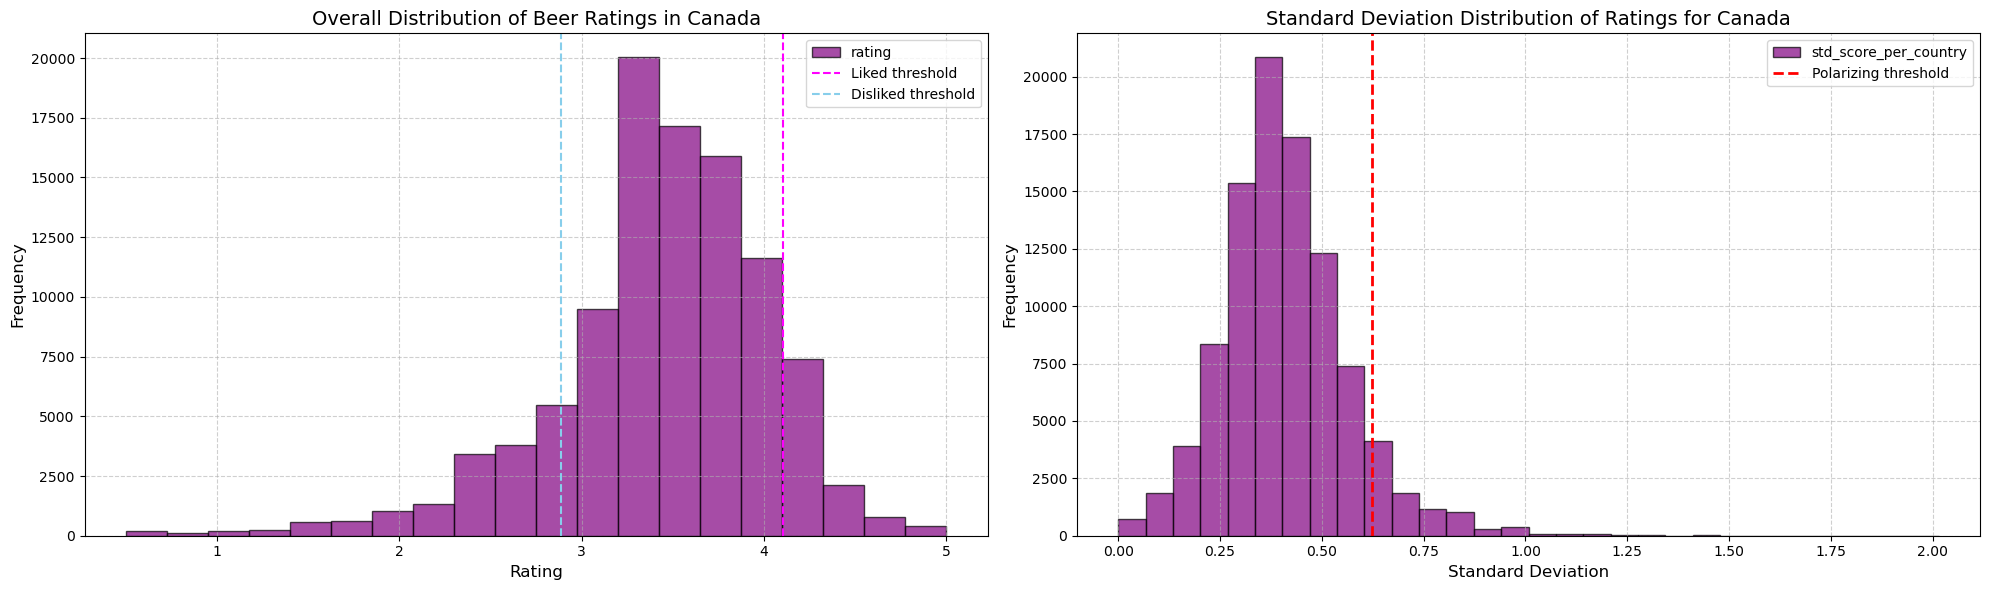

In [61]:
nlp_utils.plot_combined_distribution(df,one_sigma,minus_one_sigma)

We are interested in polarizing beers and why they are determined as polarizing. To do so, we plot a radar chart and we look at the different characteristics of the ratings. We consider beers with at least 10 ratings, to be able to have a representative standard deviation. 

/Users/Julie/Desktop/ada-2024-project-kjaaanalytics/src/utils/nlp_utils.py:297: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



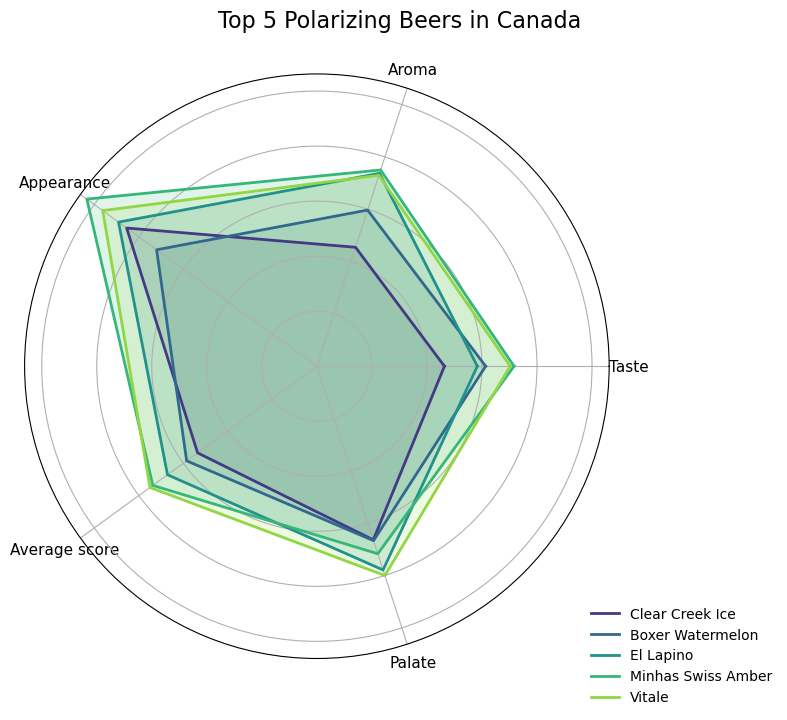

In [62]:
nlp_utils.plot_radar_chart(df, 'Canada', 'Polarizing', ['taste','aroma','appearance','avg_score_per_country','palate'])

# 4. Geospatial analysis
## 4.1.1 Climatic data

### Chelsa Data
The image is of size (20880, 43200, 3). Axis 2 is a repetition of the value, hence we get all the information we need with a (20880, 43200) array.

From the size of the image, the coordinates system used is:

- Projection: Geographic (latitude/longitude)
- Datum: WGS84 (World Geodetic System 1984)

The resolution is 30 arc seconds. When downsampling with a kernel size of 10, the resolution is ~5 arc minutes. This represents ~9.26 kilometers at the equator (should be enough for our data analysis).


In [ ]:
# Import precipitation and temperature data
# Approximate runtime: 10 minutes
DATA_FOLDER = "../MA3/04_ADA/data/"
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

tmean_data = np.zeros((12, 2088, 4320))
prec_data = np.zeros((12, 2088, 4320))
tmin_data = np.zeros((12, 2088, 4320))
tmax_data = np.zeros((12, 2088, 4320))

for i, month in enumerate(months):

    tmean_file = geospatial_utils.load_geotiff(os.path.join(DATA_FOLDER, 'temp', f"CHELSA_tmean_2013_{month}_V1.2.1.tif"))
    prec_file = geospatial_utils.load_geotiff(os.path.join(DATA_FOLDER, 'prec', f"CHELSA_prec_2013_{month}_V1.2.1.tif"))

    tmean_data[i] = tmean_file
    prec_data[i] = prec_file

# Convert temperature data to [°C]
tmean_data =  np.multiply(tmean_data, 1/10) - 273.15


Optionally, save the arrays in .npy format and load them again the next time

In [71]:
np.save(DATA_FOLDER+"tmean_data.npy", tmean_data)
np.save(DATA_FOLDER+"prec_data.npy", prec_data)

In [72]:
tmean_data = np.load(DATA_FOLDER+"tmean_data.npy")
prec_data = np.load(DATA_FOLDER+"prec_data.npy")

## 4.1.2 Geographic rasters (maps of the world and of the us)

### Natural Earth datasets have the following properties:

- has a 'geometry' column containg data of type <class 'shapely.geometry.multipolygon.MultiPolygon'>
- Datum: WGS84 but given in unit of degrees

### We download two datasets:

- *ne_110m_admin_0_countries.shp* : contains geometries of every country in the world
- *ne_50m_admin_1_states_provinces.shp* : containes geometries of regions of some big countries. We are interested in the USA.

In [73]:
''' Importing maps '''
# Import world map (with region delimitation) and select desired columns
world_all = gpd.read_file(os.path.join(DATA_FOLDER, 'ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'))
world = world_all.loc[:, ['ADMIN', 'geometry']]

# Create Dataframe containing USA states only
# We remove the states of Hawaii and Alaska for visualization purpose and because we don't need them in our analysis
states_gdf = gpd.read_file(os.path.join(DATA_FOLDER, 'ne_50m_admin_1_states_provinces/ne_50m_admin_1_states_provinces.shp'))
states_gdf_reduced = states_gdf.loc[:, ['admin', 'name', 'geometry']]
us = states_gdf_reduced[states_gdf_reduced['admin'] == 'United States of America']
us = us[us['name'] != 'Alaska']
us = us[us['name'] != 'Hawaii']
switzerland = world[world["ADMIN"] == "Switzerland"]

## 4.1.3 Beer dataset

For the beer data set, we use the *cleaned ratings* processed before.

In [74]:
data = pd.read_csv(os.path.join(DATA_FOLDER, "cleaned_ratings.csv"), index_col=0)
data["date"] = pd.to_datetime(data["date"])

/var/folders/7l/ltdxzx1s3dj_sz2kw6_5g8k00000gn/T/ipykernel_24041/3434411847.py:1: DtypeWarning:

Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.



## 4.2 Geographical representation of beer preferences

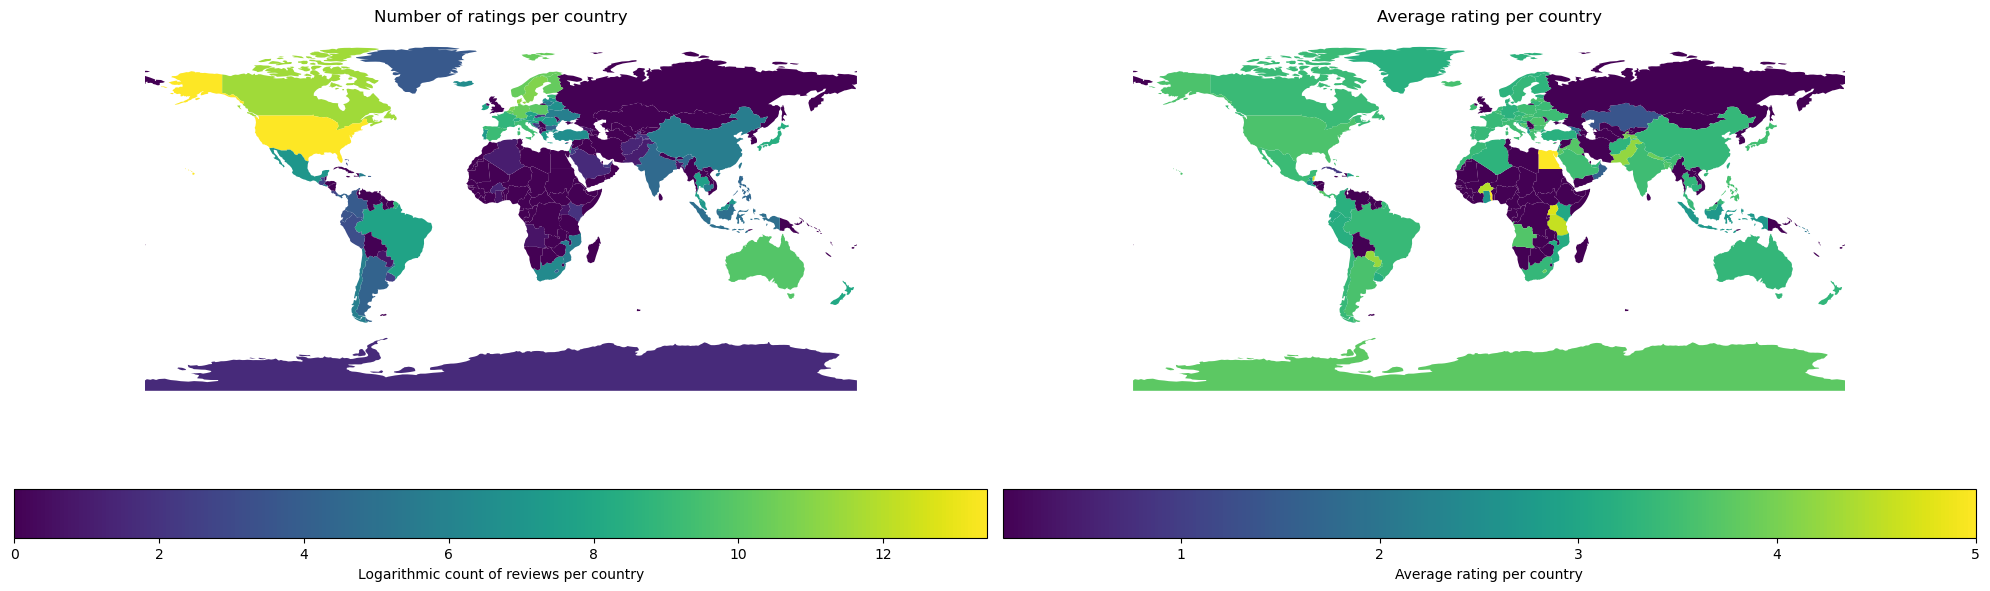

In [75]:
df = pd.read_csv(os.path.join(DATA_FOLDER, 'cleaned_ratings.csv'), low_memory=False)
geo_df = geospatial_utils.generate_geodf(df, world)
geospatial_utils.plot_geodf(geo_df)

## 4.3 Seasonal variation of temperature in Belgium

When Bob will go on his roadtrip, he wants to choose his drink according to the weather in the capital of beers! Let's look what the temperature looks like year-round in Belgium.

Run the next cell to create an animation. If it does not display well in the notebook, the animation will be saved in the folder "ouput/animations".

FileNotFoundError: [Errno 2] No such file or directory: 'output'

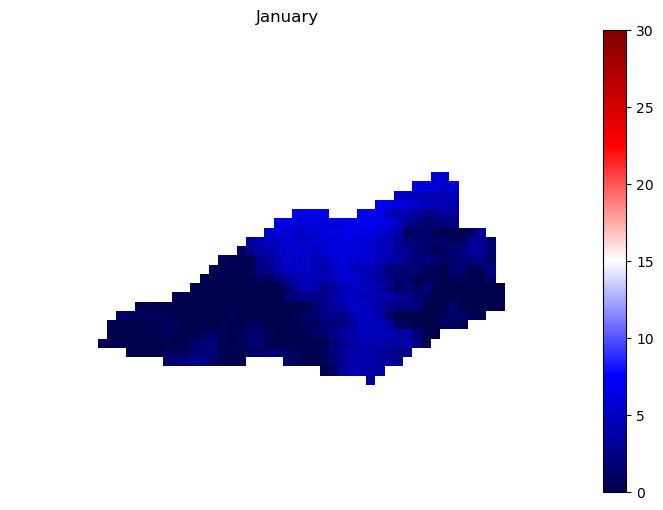

In [79]:
geospatial_utils.animation_belgium(world, tmean_data, 'temperature')

Filter the dataframe to keep only data from Belgium and add a "season" column to the dataframe by grouping the *date* column

In [80]:
data_belgium = data[(data["country_user"] == "Belgium")]

# Add a 'season' column to the DataFrame
data_belgium['season_num'] = data_belgium['date'].copy()
data_belgium['season_num'] = data_belgium['season_num'].apply(geospatial_utils.get_season)

grouped_data_belgium = data_belgium.groupby(['style','season_num'])[['rating', 'overall']].agg('mean').reset_index()

/var/folders/7l/ltdxzx1s3dj_sz2kw6_5g8k00000gn/T/ipykernel_24041/1259463523.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7l/ltdxzx1s3dj_sz2kw6_5g8k00000gn/T/ipykernel_24041/1259463523.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Find the best rated beer styles per season (the beer style with the largest average rating)

In [82]:
top_styles_per_season = geospatial_utils.get_top_styles_per_season(grouped_data_belgium)

top_styles_per_season["season"] = top_styles_per_season["season_num"].copy()
top_styles_per_season["season"] = top_styles_per_season["season"].apply(geospatial_utils.get_season_name)

AttributeError: module 'src.utils.geospatial_utils' has no attribute 'get_top_styles_per_season'

In [83]:
geospatial_utils.plot_seasonal_preferences(top_styles_per_season)

AttributeError: module 'src.utils.geospatial_utils' has no attribute 'plot_seasonal_preferences'

# 4.4 Weather differences across states in the USA

Next Bob visits the USA. What are the climatic differences across regions in the USA? 

To explore this question, the climatic data was interpolated across each region's geometric boundaries. An average was taken over each region to extract a single value per state.

First we generate a list of GeoDataFrame containing climatic data for each month of the year.

### 4.4.1 Visualize and interpolate climatic data in the US

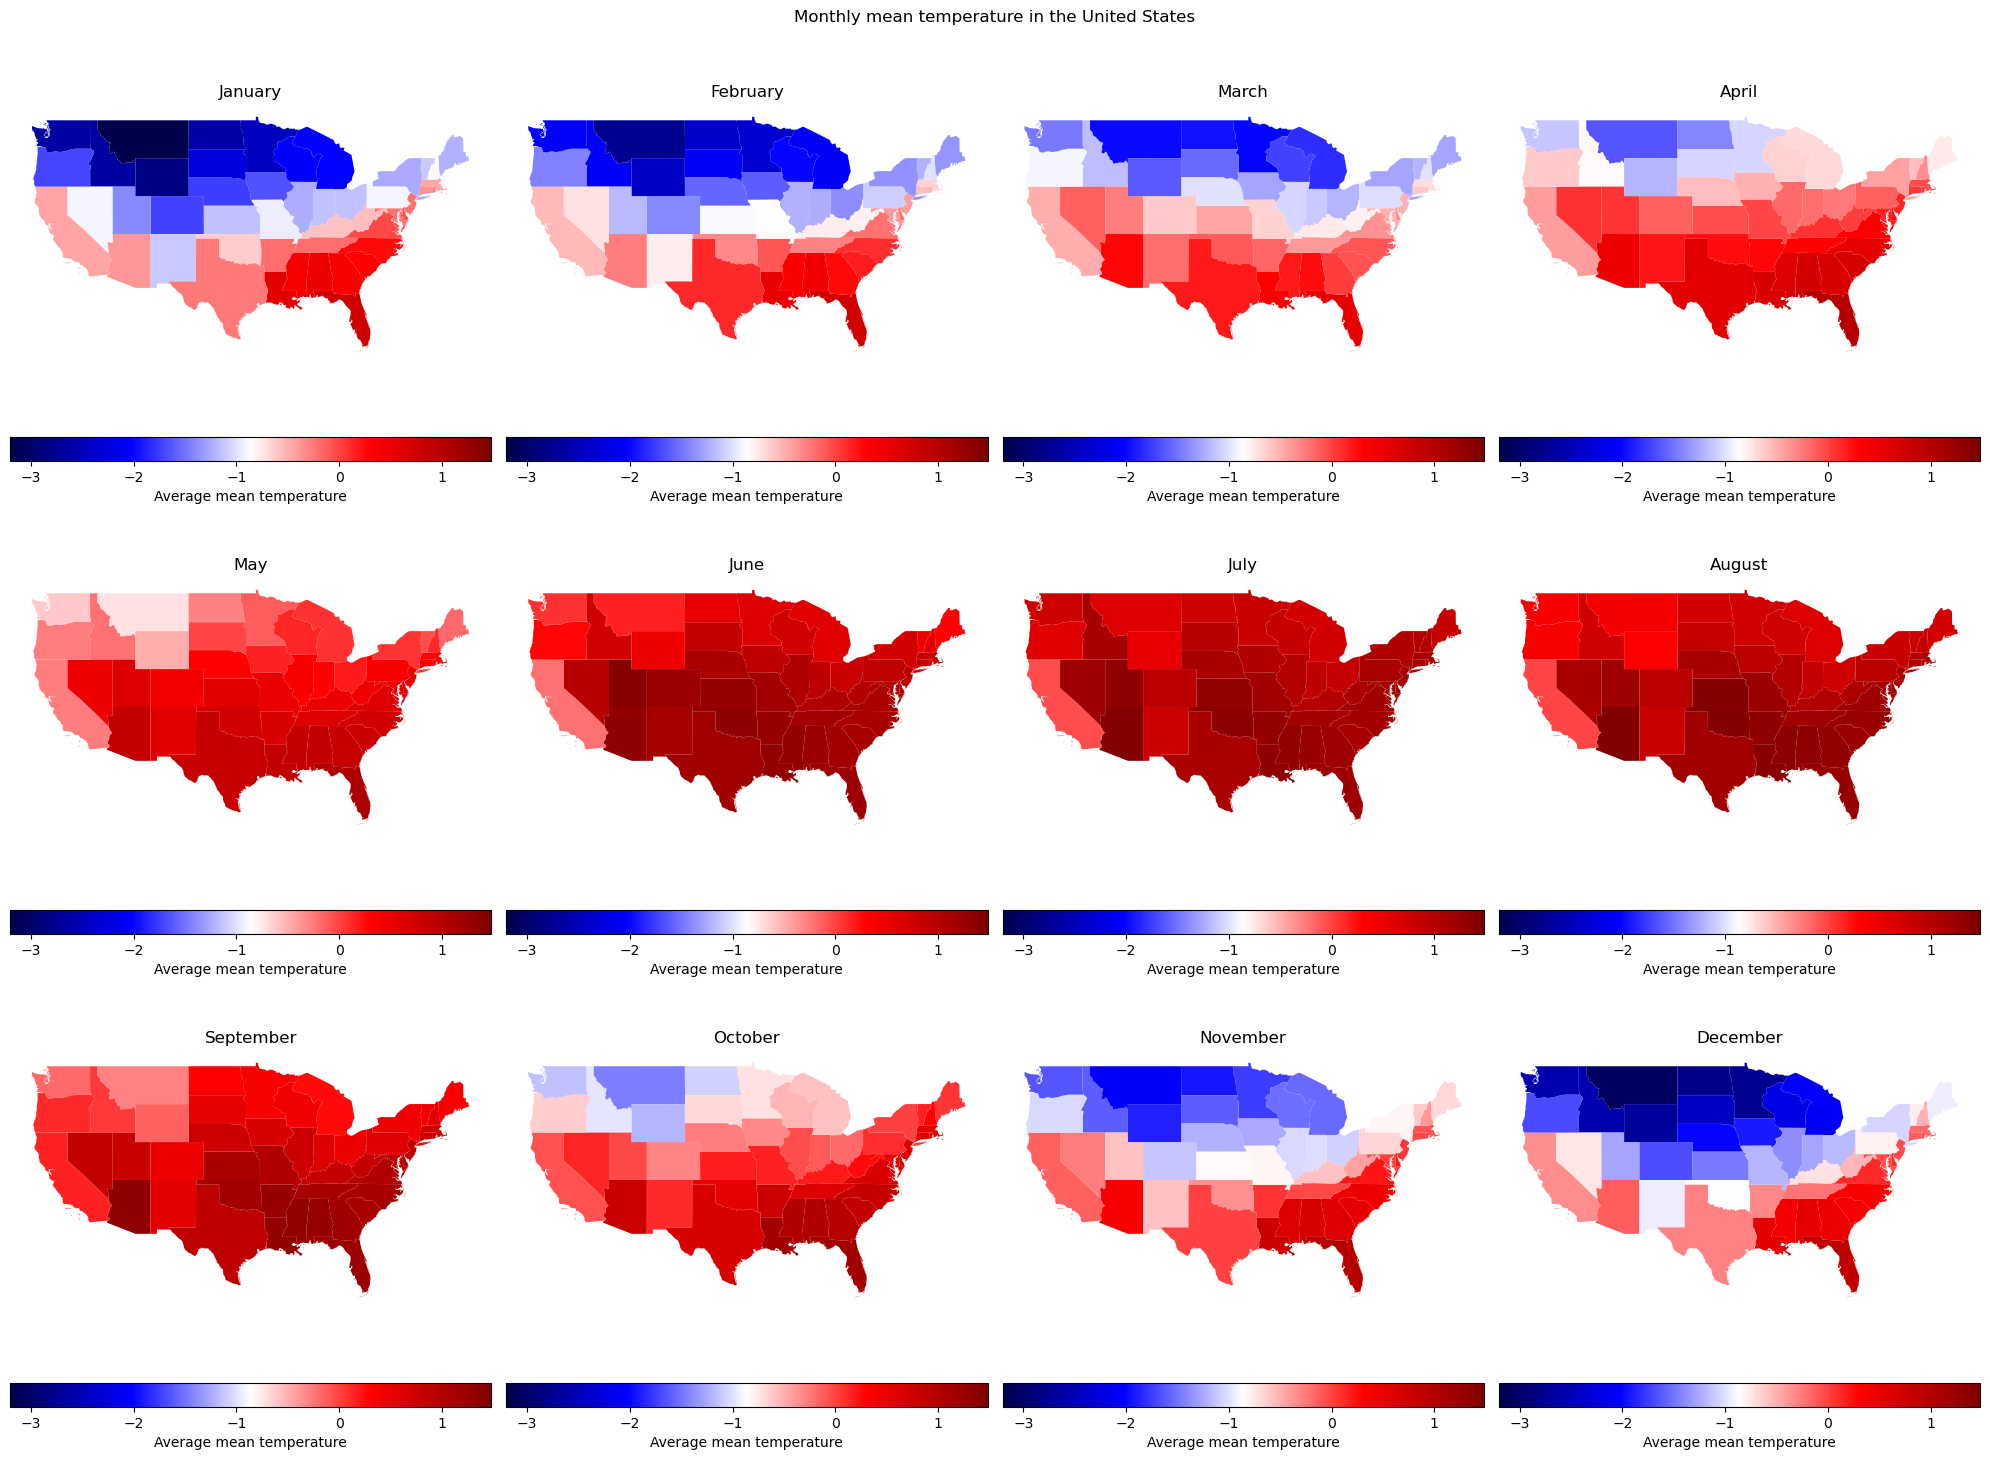

In [44]:
us_gdfs, t_stats, p_stats = geospatial_utils.generate_usgdfs(us, tmean_data, prec_data)
geospatial_utils.plot_usa(us_gdfs, 'tmean')

### 4.4.2 Weather clustering
Now, given thos informations, we would like to cluster the climatic (mean temperature and precipitation) data as to find *n* *typical climates*. This will allow us to do general analyses later on. Later on, we will classify Switzerland with the same Kmeans algorithm, so we normalize it using the same *Scaler*.

In [ ]:
us_pixel_indices, us_pixel_coords, inverse_transform = geospatial_utils.find_coordinates(tmean_data[0], us)

# Normalize american and swiss data
us_df, tmean_scaler, prec_scaler= geospatial_utils.data_preparation(tmean_data, prec_data, us)
ch_df = geospatial_utils.swiss_data_preparation(tmean_data, prec_data, switzerland, tmean_scaler, prec_scaler)

# Perform clustering
clustered_df, n_clusters, scores, ch_labels = geospatial_utils.weather_clustering(us_df, ch_df)

In [ ]:
# Interpolate labels from clustering 
majority_labels = geospatial_utils.interpolate_labels(clustered_df, us)
us["labels"] = majority_labels

# Best-rated beer styles per state
data = pd.read_csv(os.path.join(DATA_FOLDER, "cleaned_ratings.csv"), index_col=0, low_memory=False)
data_usa = data[(data["country_user"] == "United States")]

# Merge with the GeoDataFrame to plot it on a map
best_rated_per_state = geospatial_utils.get_best_rated(data_usa)
merged_gdf = best_rated_per_state.merge(us, left_on='location_user', right_on='name', how='inner')
merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry='geometry')

# Find the favorite beer style per cluster
favbeer_map = geospatial_utils.get_favbeer_map(merged_gdf)

In [ ]:
geospatial_utils.generate_analysis4_plot(us=us, n_clusters=n_clusters, kmeans_score=scores, clustered_df=clustered_df, favbeer_map=favbeer_map)

Let's now plot Switzerland to discover to which cluster it belongs!

In [ ]:
geospatial_utils.plot_switzerland(switzerland, ch_df, ch_labels)

Now that we know that the top style in the cluster Lausanne belongs is the *American double / Imperial IPA*. So, in order to produce a recommendation for Bob in Lausanne, we find the best beers of style American Double / Imperial IPA (the style recommendation for Lausanne)

In [ ]:
american_double = data[data["style"] == "American Double / Imperial IPA"]
grouped_american_double = american_double.groupby('beer_name').agg({'overall': 'mean', 'rating': 'count', 'location_brewery': list})
filtered_american_double = grouped_american_double[grouped_american_double['rating'] >= 100]
sorted_american_double = filtered_american_double.sort_values(by="overall", ascending=False)
sorted_american_double.head(50)